In [1]:
import os

#Numpy is linear algebra lbrary
import numpy as np
# Matplotlib is a visualizations library 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Data Loader
transform = transforms.Compose(
    [   transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))])

batch_size = 32


dataset = '/content/gdrive/My Drive/Covid19-dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'test')


trainset = torchvision.datasets.ImageFolder(root=train_directory, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.ImageFolder(root=test_directory, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('Normal', 'Covid', 'Viral Pneumonia')

In [4]:
train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

251
66


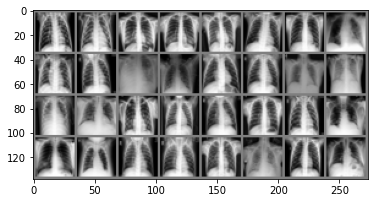

Viral Pneumonia Viral Pneumonia Covid Covid


In [5]:
def show_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
show_image(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
## 1. DEFINE MODEL 
model = nn.Sequential(nn.Linear(3072, 128),
                          nn.ReLU(),
                          nn.Linear(128, 64),
                          nn.ReLU(),
                          nn.Linear(64, 32),
                          nn.ReLU(),
                          nn.Linear(32, 3)
                          )

In [7]:
# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (0): Linear(in_features=3072, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=3, bias=True)
)

In [8]:
device

device(type='cuda', index=0)

In [9]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            #reshape images so they can be fed to a nn.Linear()
            inputs = inputs.view(inputs.size(0), -1)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                #reshape images so they can be fed to a nn.Linear()
                inputs = inputs.view(inputs.size(0), -1)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [11]:
# 4. Train the model for 10 epochs

num_epochs = 30 
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/30
Epoch : 000, Training: Loss: 1.0298, Accuracy: 44.2231%, 
		Validation : Loss : 1.0448, Accuracy: 39.3939%, Time: 14.9313s
Epoch: 2/30
Epoch : 001, Training: Loss: 1.0119, Accuracy: 44.2231%, 
		Validation : Loss : 1.0322, Accuracy: 39.3939%, Time: 15.6677s
Epoch: 3/30
Epoch : 002, Training: Loss: 0.9937, Accuracy: 44.2231%, 
		Validation : Loss : 1.0172, Accuracy: 39.3939%, Time: 15.0991s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.9719, Accuracy: 44.2231%, 
		Validation : Loss : 1.0009, Accuracy: 39.3939%, Time: 14.3742s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.9481, Accuracy: 44.2231%, 
		Validation : Loss : 0.9835, Accuracy: 39.3939%, Time: 15.0035s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.9233, Accuracy: 44.2231%, 
		Validation : Loss : 0.9636, Accuracy: 39.3939%, Time: 14.1243s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.8972, Accuracy: 44.6215%, 
		Validation : Loss : 0.9428, Accuracy: 39.3939%, Time: 13.6875s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.8717, Accura